# Modeling the effects of artesunate on erythropoesis in malariainfection

erste Version ohne Immunsystem, Medikament, aber mit Erythropoese,Parasit

In [1]:
#packages
import pandas as pd
import seaborn as sns
import numpy as np
import tellurium as te
import matplotlib.pyplot as plt

## Data von Florian

In [2]:
# import data from florian
data_df = pd.read_csv('./PADH_sample_set.csv')
data_df = data_df[['Tag', 'OIE ‰', 'infected ‰', 'Hb (g/l)', 'Retis ‰']]

data_df.head()

,Tag,OIE ‰,infected ‰,Hb (g/l),Retis ‰
0,1.0,35.849057,391.644205,9.6,NaN
1,NaN,NaN,NaN,NaN,NaN
2,3.0,199.074074,87.268519,8.1,NaN
3,4.0,350.279330,0.000000,7.6,13.3
4,NaN,NaN,NaN,NaN,NaN


![model schmeme](schema_erythropoese_6.svg)


## Steady State 

In [3]:
### Steady State

t_R_aging= 1          
t_E_death= 120 
Hkt      = 0.45
Vol_R    = 100e-15        #in l, Jorin
Vol_E    = 80e-15         #=80 fL, in l, Jorin, =MCH
Vol_blood= 1e-6          # =1µl, in l, gesamtes Blutvolumen 

# E0
## E0 aus Hämatokrit-wert abgeleitet
##Hämatokrit Formel nach E umgestellt, 
##E0 = ((Hkt * Vol_blood) - (R0 * Vol_R))/Vol_E
## einfügen von R0, nach E0 umstellen
E0 = (Hkt * Vol_blood * (t_E_death/2))/ ( ((t_E_death/2)* Vol_E) + ((t_R_aging/2)*Vol_R))
R0   = E0 * t_R_aging/ t_E_death 
#P0  = (R0 * (k_R_death +k_R_aging))/ (2^10 * k_P_aging)   
P0  = (R0* (0.001 + (np.log(2) / (1/2))))/ ((2**10) *np.log(2) / (10/2))
#print (E0, R0, P0, R0/E0, R0+E0)

#EPO flux
b   = 100
c   = 0.04
hemoglobin= 137.25001
EPO = 15
P   = P0
d   = -np.log(0.5)/P
a   = EPO * (1-np.exp(-d*P))*(1+np.exp((hemoglobin-b)*c))
J_EPO_prod  = a/ (1+np.exp((hemoglobin-b)*c))
J_EPO_decay = EPO * (1-np.exp(-d*P))

#LDH
LDH = 180  #U/l
t_halb_LDH_decay= 4
J_E_death = 64312.62500040728
J_R_death = 46.39175257731957
LDH_decay=  LDH * np.log(2)/t_halb_LDH_decay
LDH_conc_E = (LDH_decay * Vol_blood) / (J_E_death* Vol_E +J_R_death * Vol_R)

print(f'E0:{E0} \nR0:{R0} \nP0:{P0} \na:{a}  \nd:{d} \nLDH_conc_E:{LDH_conc_E} ')

E0:5567010.30927835 
R0:46391.75257731959 
P0:453.3712612598663 
a:40.77822970381671  
d:0.001528873221107508 
LDH_conc_E:6057.038462904435 


-4.999999999999998 3.25


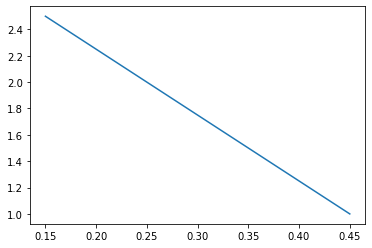

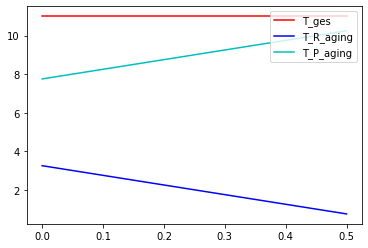

In [4]:
#RPI Zusammenhang Hamatokrit und Reifungstage von Retis in peripheren Blut (R) und Retis die in Knochenmark noch sind (Teil von P)
# https://www.labopart.de/einsender/formelberechnungen/rpi/
# s. Manuskript für Formel

Hkt = [0.15, 0.25, 0.35, 0.45] 
days_T_R_aging = [2.5, 2.0, 1.5, 1.0]
#lineare Regression for function:  y = m*x +b
m,b = np.polyfit(Hkt, days_T_R_aging, 1)
print(m,b)
plt.plot(Hkt, days_T_R_aging)
plt.show()


#x-values, and y Functions for R aging and T aging
Hkt = np.linspace(0, 0.5, 100)
T_P_aging = 5 * Hkt + 7.75
T_R_aging =-5 * Hkt + 3.25
T_ges     = T_P_aging + T_R_aging

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(Hkt,T_ges, 'r', label='T_ges')
plt.plot(Hkt,T_R_aging, 'b', label='T_R_aging')
plt.plot(Hkt,T_P_aging, 'c', label='T_P_aging')
plt.legend(loc='upper right')
plt.show()



#### Haptoglobin Steady State

## Model

In [6]:
OIE_model = """
#species initiation
EPO = 15       #in mU/mL , (Thi,2010) erreicht nach (El Hassan 1997)max. 1000 mU/mL (miliunits)
P   = 453.3712612598663    
R   = 46391.75257731959   #für SS berechnet
E   = 5567010.30927835      #cells, bezieht sich auf gesamtvolumen 1 mikroliter
niE = 0        #
iE  = 0        #in cells/(kg body weight*10^11)
diE = 0
OIE = 0        #once-infected Erys
M   = 0        #Merozoiten, Bei Infektion: 2* 10^5 (Ma, 2019)
A   = 0        #Antikörper
I   = 0        #Immun cells, bei Infektion 10^-2
LDH = 180      # U/l

#Reactions 
##erythropoisis
EPOprod:       -> EPO   ; J_EPO_prod             
EPOdecay:  EPO ->       ; J_EPO_decay
Pbirth:        -> P     ; J_P_birth
Pdeath:      P ->       ; J_P_death
Page:        P -> 1024R ; J_P_aging     # Vorläufer teilen sich ca. 10x -> 2**10
Rdeath:      R ->       ; J_R_death 
Raging:      R -> E     ; J_R_aging        
Edeath:      E ->       ; J_E_death       
##parasite lifecircle 
infect:    E+M -> iE    ; J_E_infect     
iEdeath:    iE ->       ; J_iE_death     
iErupture:  iE -> 16M   ; J_iE_rupture
Mdeath:      M ->       ; J_M_death
##Artesunate treatment
iE_ART:     iE -> diE   ; J_iE_ART     
diE_pitt:  diE -> oiE   ; J_diE_pitt 
diE_death: diE ->       ; J_diE_death 
oiEdeath:  oiE ->       ; J_oiE_death
##LDH, haptoglobin
LDHrelease:       -> LDH  ; J_LDH_release   
LDHdecay:     LDH ->      ; J_LDH_decay   

#fHbrelease:       -> fHb  ; J_fHb_release     #fHb= freies Hb im Plasma
#Hpprod:           -> Hp   ; J_Hp_prod 
#HHCbind:   fHb+ Hp-> HHC  ; J_HHC_binding     #Hp= Haptoglobin    HHC= hemoglobin-haptoglobin-complex
#HHCdecay:     HHC ->      ; J_HHC_decay       #



#parameter initiation
#Lebenszeiten t
##erythropoiesis
t_P_aging   := 5 * Hkt + 7.75          #in days, Entwicklung von Stammzelle zum Retikulozyt dauert ca. 5-9 Tage, plus 3 Tage die er schon retikulozyte ist aber noch in Rückenmark
t_R_aging   :=-5 * Hkt + 3.25          #in days, Entwicklung R -> E dauert ca 4 Tage (3 tage knochenmark, 1 Tage im peripheren Blut)-> wir betrachten nur Retis in peripheren Blut, bei niedrigen Hkt verlassen Retis eher Knochenmark,  reifen länger im Blut
t_E_death   = 120       #in 1/days, 120 Tage E Lebensdauer s. Jorins Quellen
##Infection with parasite
t_iE_rupture= 4          #in days, dauert ca 4 Tage bis Ruptur, sinuskurvig (2010 Th)
##Artesunate treatment
t_diE_pitt  = 0.25       #in days, bei Medikamentengabe nach 8h Maximum an gepitteten RBCs
t_oiE_death = 10         #in days, Lebenspanne von 7-14 Tage(Fanello,2017), 7-21 (Arguin 2014) -> dort Verweise nachgehen
##LDH
t_halb_LDH_decay = 4            #(3-5 Tage), https://www.medicoconsult.de/ldh/


#lost Parameter
KI_P_death = 15          #EPO Wert bei gesunden Menschen
##Konstanten für EPO- GG
b = 100
c = 0.04
d = -log(0.5)/P
a = EPO * (1-exp(-d*P))*(1+exp((Hb-b)*c))


#Assignments
##Erythropoese
J_EPO_prod  := k_EPO_prod         # hier später Abhängigkeit von, oiE, diE, iE einfügen (Ma, 2019) vlt (Hassan 2009)
J_EPO_decay := EPO* k_EPO_decay   #  
J_P_birth    = k_P_birth          #cells/day
J_P_death   := P * k_P_death
J_P_aging   := P * k_P_aging
J_R_death   := R * k_R_death
J_R_aging   := R * k_R_aging
J_E_death   := E * k_E_death
##Infection with parasite
J_E_infect  := E*M  * k_E_infect       # einbezug parasit?, E ersmal als Abhängigkeit ausgelassen da am Anfang E >> M -> mit Jorin absprechen+
J_iE_death  := iE * k_iE_death       #einbezug antibodies, spleen
J_iE_rupture:= iE * k_iE_rupture     #16-32M s.Cowman 2016, Anderson 1989, Diebner 2000
J_M_death   := M  * k_M_death
##Artesunate treatment
J_iE_ART    := iE  * k_iE_ART       #einbezug artesunat
J_diE_pitt  := diE * k_diE_pitt     #spleen
J_diE_death := diE * k_diE_death
J_oiE_death := oiE * k_oiE_death
##LDH, haptoglobin
J_LDH_release := (J_E_death * LDH_conc_E * Vol_E/ Vol_blood)+ (J_R_death * LDH_conc_E * Vol_R/ Vol_blood)
J_LDH_decay   := LDH * k_LDH_decay

#J_fHb_release := (J_E_death * Hb_conc_E * Vol_E) / Vol_blood
#J_Hp_prod      = k_Hp_prod (=konst.)
#J_HHC_binding := fHb * Hp * k_HHC_bind
#J_HHC_decay   := HCC * k_HCC_decay


#Raten
##Erythropoese
k_EPO_prod := a/(1+exp((Hb-b)*c) )    # in #cell/day
k_EPO_decay:= 1-exp(-P*d)             # in 1/days, (Ma, 2009)
k_P_birth   = P * (k_P_death + k_P_aging)
k_P_death  := 1/(1+ (EPO/KI_P_death))     #geraten, muss hoch sein, da wenn EPO da ist, dese so stark erringert wird dass Erythropoese verstrkt wird 
k_P_aging   = ln(2) / (t_P_aging/2)       #in 1/days
k_R_death   = 0.001                       #in 1/days,  geraten
k_R_aging   = ln(2) / (t_R_aging/2)       #in 1/days 
k_E_death   = ln(2) / (t_E_death/2)       #in 1/days       #verkürzung bei Infektion: k_E_alter; 0.15aus komischen paper 2022
##infection with parasit                       
k_E_infect  = 0                           #bei Infektion:2.0* 10^-9 keine Einheit, Ma 2019
k_iE_death  = 0.025                       #in 1/days, Ma 2019
k_iE_rupture= ln(2) / (t_iE_rupture/2)    #in 1/days
k_M_death   = 48                          #in 1/days 2010 Thi 
##Artesunate treatment
k_iE_ART    = 0.01                        # geschätzt ohne Medikament, , ART hat 1h Halbwertszeit (Tilley 2016)
k_diE_pitt  = ln(2) / (t_diE_pitt  /2)    # bei Medikamentengabe nach 8h Maximum an gepitteten RBCs
k_diE_death = 0.001
k_oiE_death = ln(2) / (t_oiE_death/2)     #in 1/days        
##LDH, haptoglobin
k_LDH_decay  = ln(2) / t_halb_LDH_decay
#k_Hp_prod    =
#k_HHC_bind  :=
#k_HCC_decay := ln(2) / (t_halb_LDH_decay)     #Halbwertszeit von LDH1 (vlt noch LDH2 betrachten!)


              
#Hämoglobin & Hämatokrit 
#Quelle:https://www.labor-und-diagnose-2020.de/index.html
#(noch diE, niE Volumen, iE, Konzentrationen hinzufügen)

##Volumen
Vol_R    = 100e-15        #in l, Jorin
Vol_E    = 80e-15         #=80 fL, in l, Jorin, =MCH
#Vol_iE   = 80e-15         #in l,   Jorin
#Vol_diE = 80e-15         #auf gleiches Volumen wie iE geschätzt
Vol_oiE  = 50e-15         #in l, Jorin
Vol_blood= 1e-6           # =1µl, in l, gesamtes Blutvolumen 

##Hb Konzentrationen
Hb_conc_R    = 300        #in g/l (Piva,2014), & Quelle Kabor & Diagnose 
Hb_conc_E    = 340        #in g/l,  =MCHC, https://www.ucsfhealth.org/medical-tests/rbc-indices    
#Hb_conc_iE  = 
#Hb_conc_diE =
#Hb_conc_oiE = 
#Hämatokrit, Hämoglobin
Hkt     := (Vol_E * E + Vol_R * R) / Vol_blood                             #0.4 ~ 40 %, #hier fehlen noch MCHC von infected Zellen
Hb      := (Vol_E * E * Hb_conc_E + Vol_R * R * Hb_conc_R) / Vol_blood     #in g/l, hier fehlen noch MCHC von infected Zellen
Hb_g_dl := Hb/10

#LDH & Haptoglobin
LDH_conc_E = 6057.038462904435 #U/l                    #https://www.ncbi.nlm.nih.gov/books/NBK557536/?report=printable
#Hb_serum := J_E_death * Hb_conc_E

#Parasitemie
p := iE / (E + R + iE + oiE + diE)  

#RPI
#Quelle: Kurth(2022),& https://www.labopart.de/einsender/formelberechnungen/rpi/
R_percent := 100* R/(R+E)
shift     := -5 * Hkt + 3.25  # in days
RPI       := R_percent * Hkt/ (shift * 0.45) 
      
"""

## Simulation

In [7]:
OIE = te.loada(OIE_model)
OIE.exportToSBML('./OIE_steadystate.xml')

31.19162312519752 0.00048456307703235443 31.191623125197538 64312.625000407286 46.3917525773196
1.0009016844005563


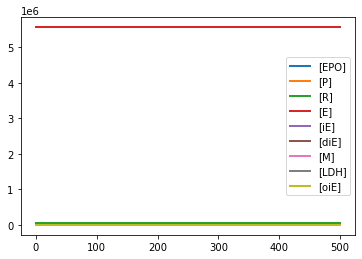

46.39175257731957 64312.62500040728


In [8]:
OIE = te.loada(OIE_model)
print(OIE.J_LDH_release,OIE.LDH_conc_E*OIE.Vol_E/OIE.Vol_blood, OIE.J_LDH_decay, OIE.J_E_death, OIE.J_R_death)

print(OIE.J_LDH_decay/(OIE.J_E_death*(OIE.LDH_conc_E*OIE.Vol_E/OIE.Vol_blood)))
result = OIE.simulate (0, 500)
OIE.plot(result)

print(OIE.J_R_death, OIE.J_E_death)



180.0


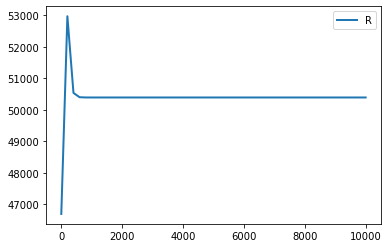

181.1265063894674


In [15]:
OIE = te.loada(OIE_model)
#OIE.setValue("E", 6*10**6) 
print(OIE.LDH)
result = OIE.simulate (0, 10000, ['time', 'R'])
OIE.plot(result)
print(OIE.LDH)

7.5 7.5


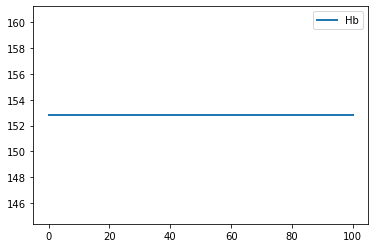

152.81443298969072


In [10]:
OIE = te.loada(OIE_model)
print(OIE.J_EPO_prod,OIE.J_EPO_decay)
#OIE.setValue("E", 9*10**6) 
result = OIE.simulate (0, 100, ['time', 'Hb'])
OIE.plot(result)
print(OIE.Hb)

In [11]:
OIE.selections

['time', 'Hb']

In [12]:
OIE.getSimulationData()

    time,      Hb
 [[    0, 152.814],
  [    2, 152.814],
  [    4, 152.814],
  [    6, 152.814],
  [    8, 152.814],
  [   10, 152.814],
  [   12, 152.814],
  [   14, 152.814],
  [   16, 152.814],
  [   18, 152.814],
  [   20, 152.814],
  [   22, 152.814],
  [   24, 152.814],
  [   26, 152.814],
  [   28, 152.814],
  [   30, 152.814],
  [   32, 152.814],
  [   34, 152.814],
  [   36, 152.814],
  [   38, 152.814],
  [   40, 152.814],
  [   42, 152.814],
  [   44, 152.814],
  [   46, 152.814],
  [   48, 152.814],
  [   50, 152.814],
  [   52, 152.814],
  [   54, 152.814],
  [   56, 152.814],
  [   58, 152.814],
  [   60, 152.814],
  [   62, 152.814],
  [   64, 152.814],
  [   66, 152.814],
  [   68, 152.814],
  [   70, 152.814],
  [   72, 152.814],
  [   74, 152.814],
  [   76, 152.814],
  [   78, 152.814],
  [   80, 152.814],
  [   82, 152.814],
  [   84, 152.814],
  [   86, 152.814],
  [   88, 152.814],
  [   90, 152.814],
  [   92, 152.814],
  [   94, 152.814],
  [   96, 152.814],
  